In [1]:
import wandb
from wandb import Api
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
from joblib import load
from dl4thermo.extras.utils import parity_plot

/Users/Kobi/Documents/Research/phd_code/dl4thermo/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext kedro.extras.extensions.ipython
%reload_kedro

[08/24/23 21:49:08] INFO     Resolved project path as:                                              ]8;id=7325;file:///Users/Kobi/Documents/Research/phd_code/dl4thermo/.venv/lib/python3.9/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=712435;file:///Users/Kobi/Documents/Research/phd_code/dl4thermo/.venv/lib/python3.9/site-packages/kedro/ipython/__init__.py#139\139]8;;\
                             /Users/Kobi/Documents/Research/phd_code/dl4thermo.                                    
                             To set a different path, run '%reload_kedro <project_root>'                           

2023-08-24 21:49:09,353 - torch.distributed.nn.jit.instantiator - INFO - Created a temporary directory at /var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/tmp7z8mu65k
2023-08-24 21:49:09,354 - torch.distributed.nn.jit.instantiator - INFO - Writing /var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/tmp7z8mu65k/_remote_module_non_scriptable.py


In [3]:
df = catalog.load("pcp_saft_regressed_pure_parameters_filtered")
fps = catalog.load("pcp_saft_regressed_pure_fps")
split_idx = catalog.load("pcp_saft_regressed_pure_parameters_split_idx")

2023-08-24 21:49:11,628 - kedro.io.data_catalog - INFO - Loading data from 'pcp_saft_regressed_pure_parameters_filtered' (CSVDataSet)...
2023-08-24 21:49:11,637 - kedro.io.data_catalog - INFO - Loading data from 'pcp_saft_regressed_pure_fps' (NumpyDataSet)...
2023-08-24 21:49:11,644 - kedro.io.data_catalog - INFO - Loading data from 'pcp_saft_regressed_pure_parameters_split_idx' (PartitionedDataset)...


In [4]:
# Download model
api = Api()
wandb_entity = "ceb-sre"
wandb_project = "dl4thermo"
wandb_run_id = "28ab02uh"
run = api.run(f"{wandb_entity}/{wandb_project}/{wandb_run_id}")
artifacts = run.logged_artifacts()  # type: ignore
targets = run.config["target_columns"]  # type: ignore
model_path = None
data_path = None
for artifact in artifacts:
    if artifact.type == "model":
        model_path = Path(artifact.download())
    elif artifact.type == "dataset":
        data_path = Path(artifact.download())
if model_path is None:
    raise ValueError("No dataset artifact found.")
model = load(model_path /"model.pkl")

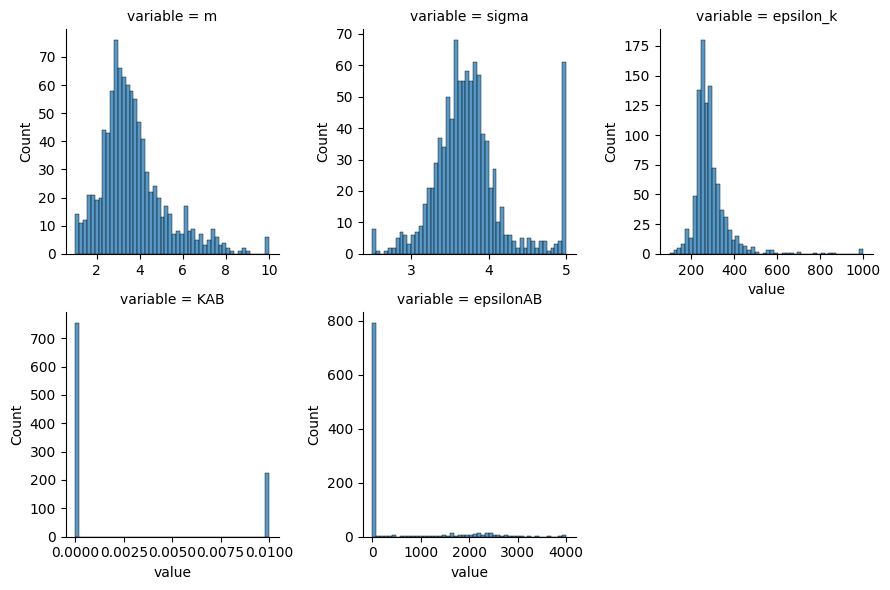

In [9]:
melted_df = pd.melt(df, id_vars=["smiles_1"], value_vars=targets)
g = sns.FacetGrid(melted_df, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.histplot, "value", bins=50)

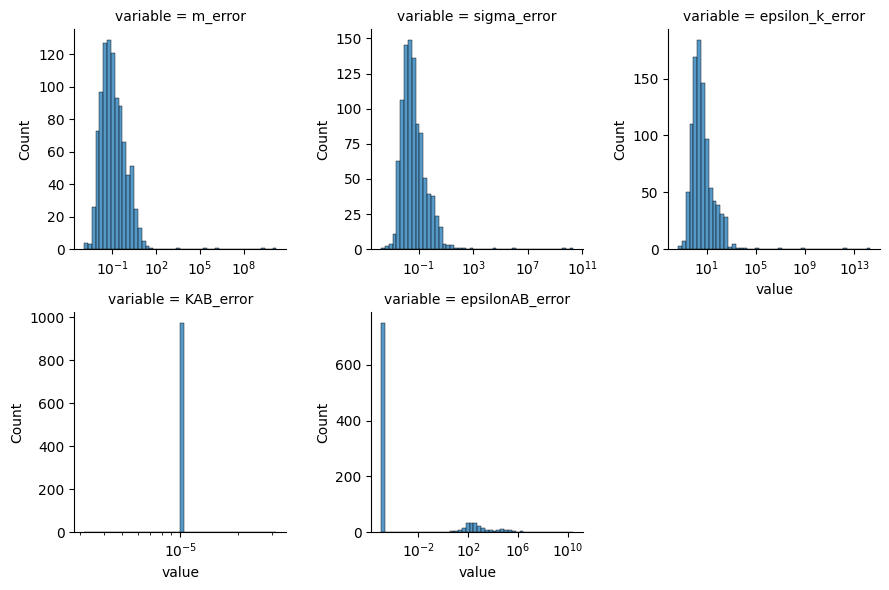

In [15]:
melted_df = pd.melt(df, id_vars=["smiles_1"], value_vars=[f"{t}_error" for t in targets])
melted_df["value"] = melted_df["value"].clip(lower=1e-5)
g = sns.FacetGrid(melted_df, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.histplot, "value", bins=50, log_scale=True)
g.figure.savefig("../data/08_reporting/pcsaft_regression_calibration/regression_uncertainty.png", dpi=300, bbox_inches="tight")
g.figure

In [93]:
# Predictions
pred_stds = []
preds = []
test_idx = split_idx["test_idx"]()

for i, e in enumerate(model.regressor_.estimators_):
    pred, std = e.predict(fps, return_std=True)
    preds.append(pred)
    pred_stds.append(std)
preds = np.array(preds).T
preds = model.transformer_.inverse_transform(preds)
var_scale = model.transformer_.var_
pred_stds = np.array(pred_stds).T
var_scale = model.transformer_.var_
pred_stds = pred_stds * np.sqrt(var_scale)
df_pred = df.copy()
for i, col in enumerate(targets):
    df_pred[f"{col}_pred"] = preds[:, i]
    df_pred[f"{col}_pred_std"] = pred_stds[:, i]

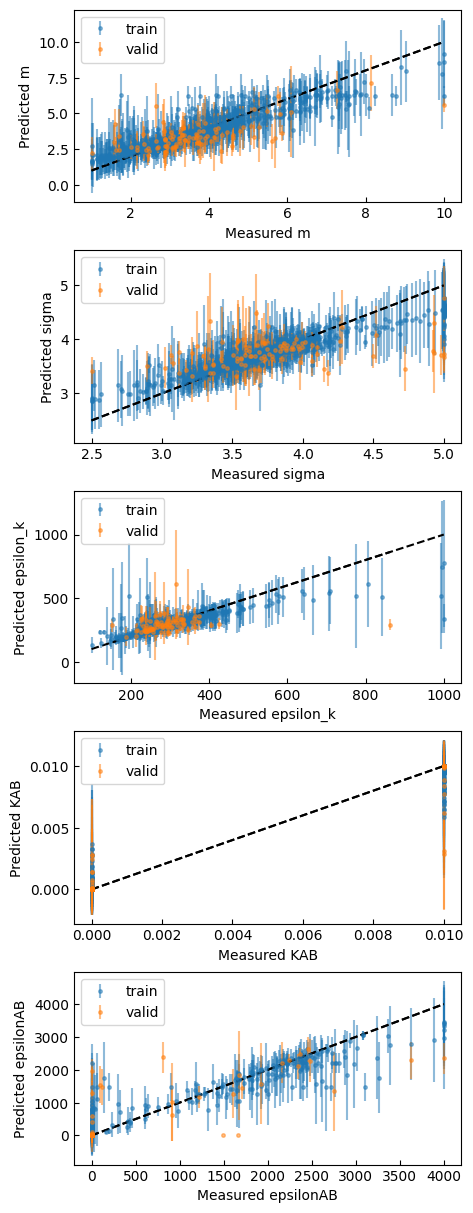

In [103]:
fig, axes = plt.subplots(5,1, figsize=(5, 15))
fig.subplots_adjust(hspace=0.25)
for i, col in enumerate(targets):
    for split in ["train", "valid"]:
        df_split = df_pred.iloc[split_idx[f"{split}_idx"]()]
        parity_plot(
            df_split[col],
            df_split[f"{col}_pred"],
            yerr=df_split[f"{col}_pred_std"],
            ax=axes[i],
            ms=2.5,
            label=split,
            quantity_name=col,
        )
    axes[i].legend()
fig.savefig("../data/08_reporting/pcsaft_regression_calibration/rf_lolo_parity_uncertainty.png", dpi=300)

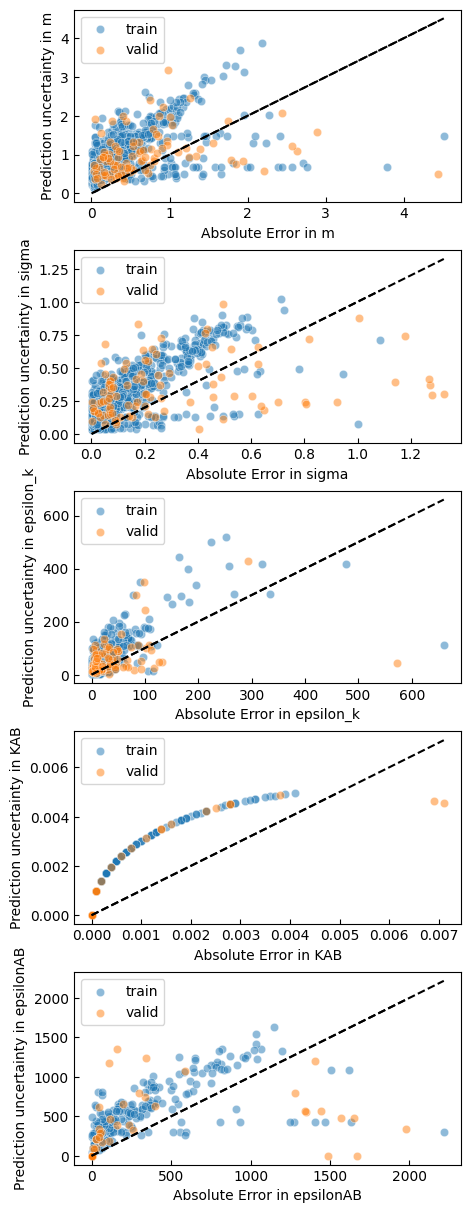

In [102]:
fig, axes = plt.subplots(5,1, figsize=(5, 15))
fig.subplots_adjust(hspace=0.25)
for i, col in enumerate(targets):
    for split in ["train", "valid"]:
        df_split = df_pred.iloc[split_idx[f"{split}_idx"]()]
        absolute_error = np.abs(df_split[col] - df_split[f"{col}_pred"])
        parity_plot(
            absolute_error,
            df_split[f"{col}_pred_std"],
            ax=axes[i],
            # ms=2.5,
            label=split,
            quantity_name=col,
        )
    axes[i].set_xlabel(f"Absolute Error in {col}")
    axes[i].set_ylabel(f"Prediction uncertainty in {col}")
    axes[i].legend()
    
fig.savefig("../data/08_reporting/pcsaft_regression_calibration/rf_lolo_uncertainty_calibration.png", dpi=300)

2023-08-23 23:59:03,046 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


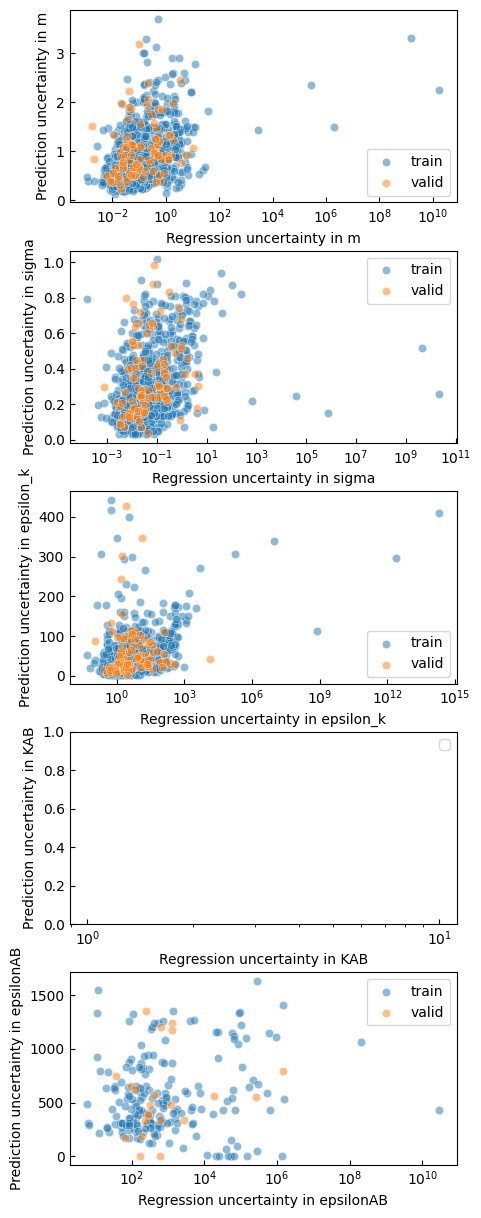

In [100]:
fig, axes = plt.subplots(5,1, figsize=(5, 15))
fig.subplots_adjust(hspace=0.25)
for i, col in enumerate(targets):
    for split in ["train", "valid"]:
        df_split = df_pred.iloc[split_idx[f"{split}_idx"]()]
        df_split = df_split[df_split[f"{col}_error"] >0]
        parity_plot(
            df_split[f"{col}_error"],
            df_split[f"{col}_pred_std"],
            ax=axes[i],
            label=split,
            include_parity=False,
            quantity_name=col,
        )
    axes[i].set_xscale("log")
    axes[i].set_xlabel(f"Regression uncertainty in {col}")
    axes[i].set_ylabel(f"Prediction uncertainty in {col}")
    axes[i].legend()
fig.savefig("../data/08_reporting/pcsaft_regression_calibration/rf_lolo_uncertainty_regression.png", dpi=300)